# In Depth: Linear Regression
Just as naive Bayes (discussed earlier in In Depth: Naive Bayes Classification) is a good starting point for classification tasks, linear regression models are a good starting point for regression tasks. Such models are popular because they can be fit very quickly, and are very interpretable. You are probably familiar with the simplest form of a linear regression model (i.e., fitting a straight line to data) but such models can be extended to model more complicated data behavior.

In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fir to data. A straight-line is a model of the form 

$ y = ax + b$

Where *a* is commonly known as the slope, and $b$ is commonly known as the intercept.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5.

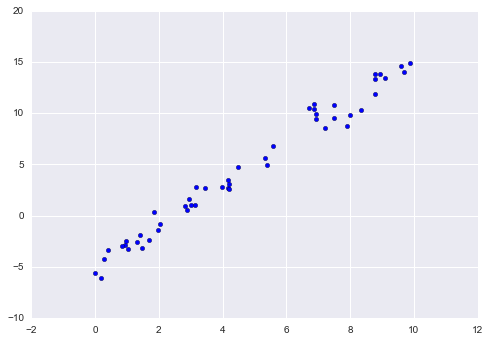

In [3]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y)

We can use sci-kit learn's LinearRegression estimator to fit this data and construct the best-fit line.


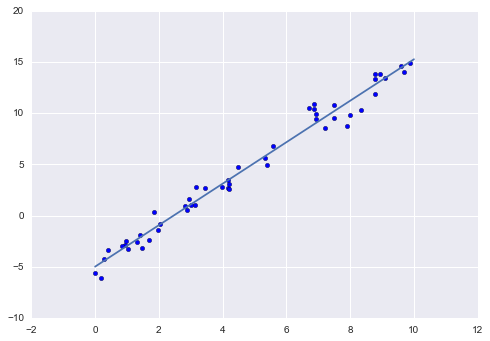

In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

The slope and intercept of the data are contained in the model's fit parameters, which in scitkiut-learn are always makered by a trailing underscore. THere the relevantr paramerrtesr are *coef_* and *intercept_*

In [6]:
print("Model slope:    ", model.coef_[0])
print("model intercept:", model.intercept_)


Model slope:     2.02720881036
model intercept: -4.99857708555


We see that the results are very close to the inputs, as we might hope.

The LinearRegression estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form
y=a0+a1x1+a2x2+⋯
y=a0+a1x1+a2x2+⋯
where there are multiple xx values. Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [8]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5
[ 1.5 -2.   1. ]


Here the yy data is constructed from three random xx values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single LinearRegression estimator to fit lines, planes, or hyperplanes to our data. It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

# Basis Function Regression
One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to basis functions. We have seen one version of this before, in the PolynomialRegression pipeline used in Hyperparameters and Model Validation and Feature Engineering. The idea is to take our multidimensional linear model:

$y=a0+a1x1+a2x2+a3x3+⋯$

and build the x1,x2,x3, and so on, from our single-dimensional input $x$. That is, we let $x_n = f_n(x)$, where $fn()$ is some function that transforms our data.

For example, if $f_n(x)=x^n$, our model becomes a polynomial regression:

$y=a_0+a_1x+a_2x^2+a_3x^3+⋯$
Notice that this is still a linear model—the linearity refers to the fact that the coefficients anan never multiply or divide each other. What we have effectively done is taken our one-dimensional xx values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between *x* and *y*.

## Polynomial basis functions
This polynomial projection is useful enough that it is built into Scikit-Learn, using the PolynomialFeatures transformer:

In [10]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value. This new, higher-dimensional data representation can then be plugged into a linear regression.

As we saw in Feature Engineering, the cleanest way to accomplish this is to use a pipeline. Let's make a 7th-degree polynomial model in this way:

In [11]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$. For example, here is a since wave with noise

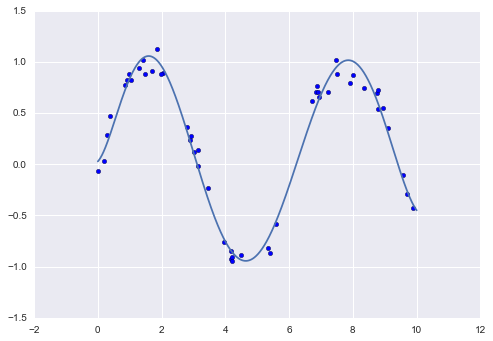

In [14]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)


poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data!

## Gaussian basis functions

Of course, other basis functions are possible. For example, one useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases. The result might look something like the following figure:

In [19]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url = "http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.06-gaussian-basis.png")



The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data. These Gaussian basis functions are not built into Scikit-Learn, but we can write a custom transformer that will create them, as shown here and illustrated in the following figure (Scikit-Learn transformers are implemented as Python classes; reading Scikit-Learn's source is a good way to see how they can be created):

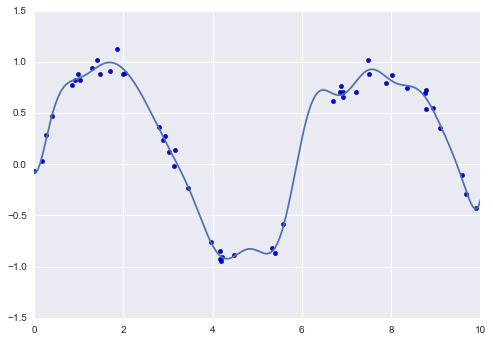

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

We put this example here just to make clear that there is nothing magic about polynomial basis functions: if you have some sort of intuition into the generating process of your data that makes you think one basis or another might be appropriate, you can use them as well.

## Regularization
The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting (refer back to Hyperparameters and Model Validation for a discussion of this). For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

(-1.5, 1.5)

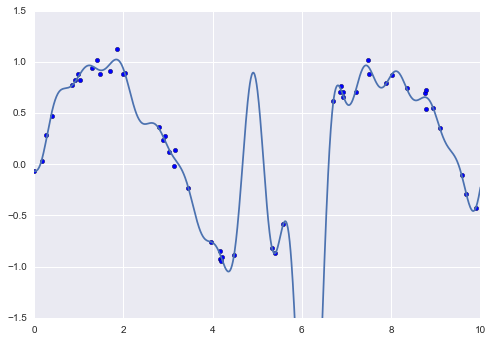

In [22]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())

model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)

With the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data. We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

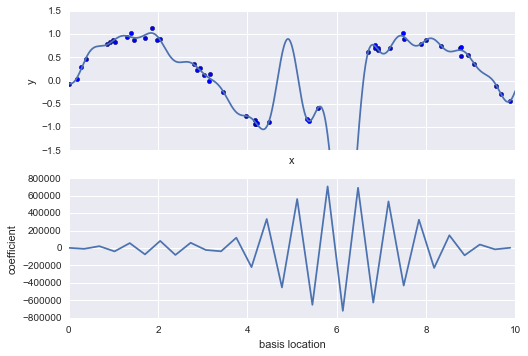

In [29]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)


The lower panel of this figure shows the amplitude of the basis function at each location. This is typical over-fitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out. We know that such behavior is problematic, and it would be nice if we could limit such spikes expliticly in the model by penalizing large values of the model parameters. Such a penalty is known as regularization, and comes in several forms.

## Ridge regression ($L_2$ Regularization)
Perhaps the most common form of regularization is known as ridge regression or $L_2$ regularization, sometimes also called Tikhonov regularization. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be

$P=α∑^n=1Nθn2$

where αα is a free parameter that controls the strength of the penalty. This type of penalized model is built into Scikit-Learn with the Ridge estimator: